# A quantum adversarial learning approach to learn sequential data distributions

The following notebook evaluates the learnability of a conditional quantum generative adversarial network in a semi-supervised learning setting. Using 15 days of arbitrary prior `DIS` stock prices as conditional labels to the quantum generator, I employ an adversarial learning approach with a classical discriminator to train the generator to learn as many sequential data sequences of 19 days as it can (15 days input, 4 days predict). After our attempts with simple quantum neural networks and reading through relevant literature, I've settled that the hope here is not for the generator to learn the underlying distribution of `DIS` stock price data but rather to numerically determine the capacity and power of a quantum generative adversarial network in learning a given number of sequential data samples. To that end, I use this QGAN template to experiment with various hyperparameter configurations to see which work better. The results of those experiments and related metric charts can be found [here](https://www.notion.so/Hyperparameter-tuning-logs-55900faebff8456394cd44a7ea235997).

<hr>

## Imports

In [1]:
import pennylane as qml
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
wires = range(15)
n_layers = 3
dev = qml.device('default.qubit', wires=wires)

###### dataset structure: `[equity number][train or test][sample number][past or future]`

In [3]:
dataset = np.load('data/dataset.npy', allow_pickle=True)

dis_dataset = dataset[1]

## Structure of QGAN

### Generator

In [4]:
@qml.qnode(dev, interface="tf")
def gen_circuit(b_seq, gen_weights):
    # Embedding past time series onto circuit as conditional labels
    qml.templates.AngleEmbedding(b_seq, wires, rotation='X')
        
    # Adjusting parameters of generator ansatz
    qml.templates.StronglyEntanglingLayers(gen_weights, wires=wires)
    
    # Returning normalized percentage price predictions for next 4 days in dataset 
    return [qml.expval(qml.PauliZ(i)) for i in range(len(dis_dataset[0][1][1]))]

In [5]:
init_gen_weights = tf.Variable(np.random.uniform(-np.pi, np.pi, (n_layers, len(wires), 3)))

In [6]:
init_gen_weights

<tf.Variable 'Variable:0' shape=(3, 15, 3) dtype=float64, numpy=
array([[[-0.88701635, -1.54912501, -0.8525112 ],
        [-1.53692466,  2.95251868,  2.23696445],
        [-2.42279275,  1.84587814,  3.04860206],
        [ 2.83959698,  1.26262586, -0.08396601],
        [ 1.29138745, -2.56281357, -2.08070518],
        [-1.26814322,  0.47261909,  1.62131253],
        [-2.41086223,  0.99930757, -1.99027519],
        [-0.72379049, -1.77472708, -1.97173395],
        [ 1.51763824, -2.55807908,  0.12068614],
        [ 0.45750247, -0.73728982, -1.31661051],
        [ 1.39348662, -3.02674522,  0.62734753],
        [ 2.2679303 , -2.37242893, -1.26380886],
        [-2.78996186, -0.34997719,  2.14067192],
        [-0.08138569,  2.91907192,  0.42401964],
        [-1.17377137,  1.39837493, -0.52559872]],

       [[-1.89646083, -1.54066761, -2.08148989],
        [ 0.04691366,  0.04150308, -3.1255754 ],
        [ 0.55573674,  2.97993866, -1.77767168],
        [-1.16331778, -1.12303346, -1.43656612],
  

In [7]:
# Testing generator circuit QNode
gen_circuit(dis_dataset[0][1][0], init_gen_weights)

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([ 1.55092621e-05, -1.69353143e-03, -1.00086526e-02,  9.36802328e-03])>

### Discriminator

In [8]:
def make_discrim():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=1, input_shape=[1, 19]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=1))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Dropout(.3))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    return model

In [10]:
discriminator = make_discrim()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1, 16)             320       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             272       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1, 16)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 16)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 128)            2176      
_________________________________________________________________
dense_3 (Dense)              (None, 1, 1)             

### Loss functions and optimizers — real is 1, fake is 0

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def generator_loss(fake_output):
    """Calculating loss"""
    return cross_entropy(np.ones_like(fake_output), fake_output)

In [13]:
def discriminator_loss(fake_output, real_output):    
    """Compute discriminator loss.""" 
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def accuracy(real_data, fake_data):
    m = tf.keras.metrics.MeanAbsoluteError()
    m.update_state(real_data, fake_data)
    acc = 1 - m.result().numpy()
    return acc

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0001)

### Train step definition

In [16]:
def train_step(equity_data, gen_weights):
    """Run train step on provided image batch."""
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape: 
        generated_prices = tf.concat([equity_data[0], gen_circuit(equity_data[0], gen_weights)], 0)
        generated_prices = tf.reshape(generated_prices, (1,1,(len(equity_data[0]) + len(equity_data[1]))))

        real_prices = tf.concat([equity_data[0], equity_data[1]], 0)
        real_prices = tf.reshape(real_prices, (1,1,(len(equity_data[0]) + len(equity_data[1]))))
        
        """Getting outputs from discrim"""
        real_output = discriminator(real_prices)
        fake_output = discriminator(generated_prices)
        
        """Calculating loss"""
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(fake_output, real_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, gen_weights)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip([gradients_of_generator], [gen_weights]))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    """Accuracy"""
    acc = accuracy(equity_data[1], gen_circuit(equity_data[0], gen_weights))
    
    return gen_loss, disc_loss, gen_weights, acc

### Training

In [18]:
gloss = []
dloss = []
acc_results = []
epoch_acc_results = []

In [19]:
EPOCHS = 2500
batch_size = 1

def train(dataset, epochs, start_epoch=1, new_gen_w=None):    
    for epoch in range(start_epoch, start_epoch + epochs):
        if epoch == 1:
            new_gen_w = tf.Variable(np.ones_like(init_gen_weights.numpy()), dtype="float64")
            new_gen_w.assign(init_gen_weights)
        
        for i, sample in enumerate(dataset[0:batch_size]):
            sample_b = sample[0]
            sample_f = sample[1]
            gl, dl, w, acc = train_step(dataset[i], new_gen_w)
            
            new_gen_w.assign(w)
            acc_results.append(acc)
            gloss.append(gl)
            dloss.append(dl)
        
            if epoch % 10 == 0:
                print(f"Step {i} in {epoch} epoch: Gen loss: {gl} \n         Disc loss: {dl} \n             Accuracy: {acc}")
        
        epoch_acc = 0
        for i, sample in enumerate(dataset[0:batch_size]):
            epoch_acc += accuracy(sample[1], gen_circuit(sample[0], new_gen_w))
        epoch_acc = epoch_acc / len(dataset[0:batch_size])
        epoch_acc_results.append(epoch_acc)

    return new_gen_w

In [20]:
new_gen_w = train(dis_dataset[0], EPOCHS, start_epoch=1) 

Step 0 in 10 epoch: Gen loss: 0.6624584197998047 
         Disc loss: 1.3695714473724365 
             Accuracy: 0.7976694703102112
Step 0 in 20 epoch: Gen loss: 0.6642863154411316 
         Disc loss: 1.3580408096313477 
             Accuracy: 0.7979502081871033
Step 0 in 30 epoch: Gen loss: 0.6664671301841736 
         Disc loss: 1.3484387397766113 
             Accuracy: 0.7982464283704758
Step 0 in 40 epoch: Gen loss: 0.6695736646652222 
         Disc loss: 1.3393096923828125 
             Accuracy: 0.798551395535469
Step 0 in 50 epoch: Gen loss: 0.67249596118927 
         Disc loss: 1.330273985862732 
             Accuracy: 0.7988499850034714
Step 0 in 60 epoch: Gen loss: 0.6750047206878662 
         Disc loss: 1.3211067914962769 
             Accuracy: 0.799131765961647
Step 0 in 70 epoch: Gen loss: 0.677492082118988 
         Disc loss: 1.312382459640503 
             Accuracy: 0.7994423508644104
Step 0 in 80 epoch: Gen loss: 0.6826159954071045 
         Disc loss: 1.30361509323

### Visualizing training metrics

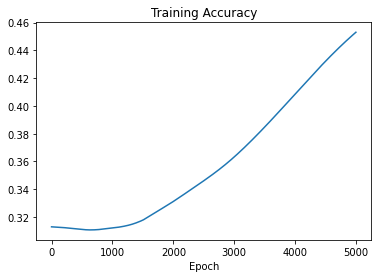

In [270]:
plt.plot(range(len(epoch_acc_results)), epoch_acc_results)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.show()

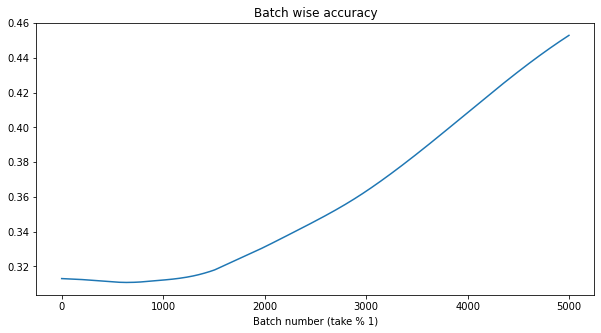

In [271]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(acc_results)), acc_results)
plt.title("Batch wise accuracy")
plt.xlabel(f"Batch number (take % {batch_size})")
plt.show()

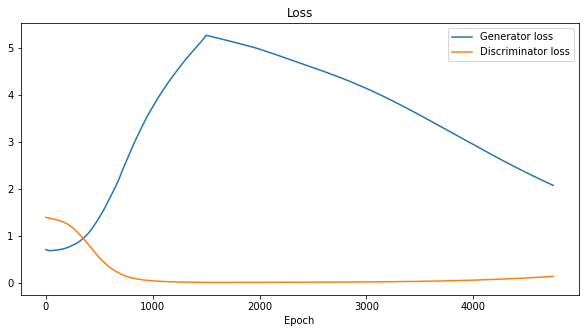

In [268]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(gloss)), gloss, label="Generator loss")
plt.plot(range(len(dloss)), dloss, label="Discriminator loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Learned distribution performance

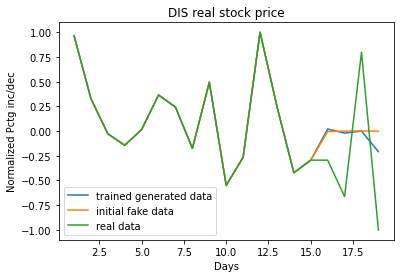

In [241]:
for i in range(batch_size):
    days =  np.arange(1, len(dis_dataset[0][0][0]) + len(dis_dataset[0][0][1]) + 1)
    real_stats = np.append(dis_dataset[0][i][0], dis_dataset[0][i][1])
    fake_stats = tf.concat([dis_dataset[0][i][0], gen_circuit(dis_dataset[0][i][0], new_gen_w)], 0).numpy()
    init_fake_stats = tf.concat([dis_dataset[0][i][0], gen_circuit(dis_dataset[0][i][0], init_gen_weights)], 0).numpy()

    plt.plot(days, fake_stats, label="trained generated data")
    plt.plot(days, init_fake_stats, label="initial fake data")
    plt.plot(days, real_stats, label="real data")
    plt.title("DIS real stock price")
    plt.xlabel("Days")
    plt.ylabel("Normalized Pctg inc/dec")
    plt.legend()
    plt.show()

## Prior performance charts from hyperparameter tuning [log](https://www.notion.so/Hyperparameter-tuning-logs-55900faebff8456394cd44a7ea235997)

![](./images/qgan_ex_1.png)
![](./images/qgan_ex_2.png)
![](./images/qgan_ex_3.png)
![](./images/qgan_ex_4.png)
![](./images/qgan_ex_5.png)

<hr>

## Conclusion

As observed through our experiments with the QGAN, it suffers from vanishing gradients requiring dynamic monitoring and LR scheduling. Beyond that, it's evident through the performance charts that with the current configuration it is comfortably learning up to 2 distinct 19-day time sequences of data. As a next step, I would attempt solving this machine learning task with a Wasserstein hybrid-quantum generative adversarial network to tackle the problem of vanishing gradients.